# All settings will be given to the channel 1 output, in the DC Amp out configuration

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from time import sleep
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *
from PulseFiles import *
from Instrument import *
import pyqtgraph as pg 
import nidaqmx

# Visa interface for the M8190A instrument:

In [2]:
M8190A = VisaR(AWG_Settings2,60000)

In [3]:
Initialization(M8190A,AWG_Settings2)

Instruments Sampling Frecuency set to 5.00000000000000E+08Hz
Instruments DC1 Output route Voltage set to 7.00000000000000E-01deciVolts


In [4]:
M8190A.query('*IDN?')

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2'

In [6]:
M8190A.write('*RST')

5

In [5]:
M8190A.query('FREQ:RAST?')

'5.00000000000000E+08'

In [6]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [8]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


# Loading a single waveform:

In [5]:
#triggering related to M8190A.write(':INIT:GATE1 0')
# M8190A.write(':INIT:CONT1 0')
#15ms time length
#maybe I have to modified this function to account for different loops on TRAC subsystem with instrument.write(':TRAC1:COUN L'); with L the number of desired loops

Segment_File(M8190A,"D:\Alejandro\Pulses\Dict\S2\SegmentA_7500000_1.csv",1)


In [9]:
M8190A.write(':INIT:GATE1 0')
M8190A.write(':INIT:CONT1 0')

14

In [10]:
M8190A.write('INIT:IMM')

9

In [11]:
M8190A.write('ABOR')

5

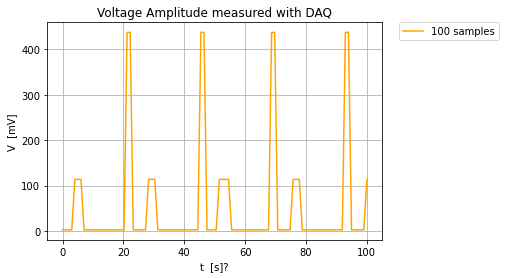

In [22]:
task = nidaqmx.Task()

task.ai_channels.add_ai_voltage_chan("DAQBNC1/ai0",min_val=-0.2,max_val=0.5)

task.start()

N = 100


data_on = np.array(task.read(N))



task.stop()
task.close

tom = np.linspace(0,N,N)


fig,ax= plt.subplots()

ax.grid(True)
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(tom,data_on*1000,label= '{b} samples'.format(b=N),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]?')
ax.set_title('Voltage Amplitude measured with DAQ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [44]:
data_on.shape

(100,)

# Trigger documentation: AWG manual pp 106
## Sequencing mode either arbitrary or STS

## Trigger Mode in Triggered 

## Advance mode options:
    1. Auto: The segment is executed the number of times specified by its loop count. Then the last sample is played at the end.
    2. Repeat: This advancement mode is quite the same like “Auto” with the difference that an advancement event is required at the end.
    3. Single: An advancement event is required for each segment repetition.
    4. Conditional: The segment is played infinitely after receiving a trigger. After being stopped (See SCPI command :ABORt[1|2]) the offset value is played.

    :ARM:TRIG:LEV 0.4 = 400mV threshold for trigger in, goes from-5V to 5V

In [40]:
val = 0.5
M8190A.write('ARM:TRIG:LEV {v}'.format(v = val))

17

In [49]:
trigger_task = nidaqmx.Task()

trigger_task.ao_channels.add_ao_voltage_chan('DAQBNC1/ao0','triggering',0,4)
trigger_task.start()

val = 0

trigger_task.write(val)

trigger_task.stop()
trigger_task.close()

In [37]:
trigger_task.close()

C:\Users\a.hernandez.de.la.ve\Anaconda3\lib\site-packages\nidaqmx\task.py:461: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<1D>" but task was already closed.
  warnings.warn(


In [43]:
M8190A.query('ARM:TRIG:SOUR?')
M8190A.query(':ARM:TRIG:SLOP EITH')

'EXT'

In [44]:
M8190A.query('ARM:TRIG:LEV?')

'5.00000000000000E-01'

In [47]:
DataFramesPSscheme['SegmentA_7500000_1']

,Y1,SyncMarker1,SampleMarker1
0,0.000000,1,1
1,0.571429,1,1
2,0.571429,1,1
3,0.571429,1,1
4,0.571429,1,1
...,...,...,...
7499995,0.000000,1,1
7499996,0.000000,1,1
7499997,0.000000,1,1
7499998,0.000000,1,1


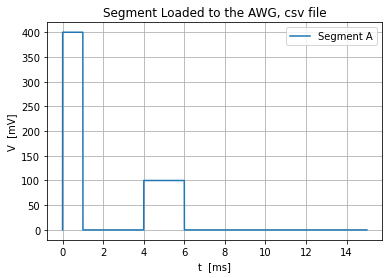

In [51]:
fig,ax= plt.subplots()

ax.grid(True)

plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_1']['Y1']*AWG_Settings2['Voltage Amplitude'],label= 'Segment A')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Segment Loaded to the AWG, csv file')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [13]:
#Dummy version below!


tic = time.time()

DataFramesPSscheme, DataFramesPSschemes2 , timeinterval = Sequence_Loader_List(PScheme,PScheme2,5,15,7500000,0,5,M8190A,AWG_Settings2,1,10)

toc = time.time()

dur = toc -tic

KeyboardInterrupt: 

In [12]:
#for 10 secs sleep time, after reset, complete sequence, first one showed for 5 seconds
dur

213.98125910758972

In [6]:
#for 10 secs sleep time, after reset, complete sequence, first one showed for 5 seconds
dur

215.16026377677917

In [8]:
#for 10 secs sleep time, after sequence, complete sequence, first one lasted aroud 10s
dur


214.71261024475098

### Up till now I load the sequence into the AWG and inmidiatly play it , this causes certain delay during the sequencing scheme since it takes some time to load the data into the AWG. This may lead to problems as this delay then must be taken into account within the duration of the measurement scheme to get the "proper" measurement time.

A better option, in theory, would be to "separate" my current loading function, into a function that only loads the given data into the sequence table subsystem, and a function that iterates the INIT:IMM SCPI command over the loaded sequences.

After doing test runs I have noticed that when trying to access different sequences within the sweeping scheme, all the sequences stored in the AWG correspond to the last sweeping step of the scheme, this should not happen. Maybe this is due to having the advance condition set to "Auto" ?. 

The problem maybe with the data CSV files, as up til know I-ve plotted the data frame associated to it during the run, but not the one at the end of the sweep.


In [9]:
dur

191.83281588554382

In [48]:
timeinterval

array([0.00000000e+00, 2.00000027e-06, 4.00000053e-06, ...,
       1.49999960e+01, 1.49999980e+01, 1.50000000e+01])

# Checking the Data Frames

In [9]:
DataFramesPSscheme

{'SegmentA_7500000_2':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.666667            1              1
 2        0.666667            1              1
 3        0.666667            1              1
 4        0.666667            1              1
 ...           ...          ...            ...
 7499995  0.000000            1              1
 7499996  0.000000            1              1
 7499997  0.000000            1              1
 7499998  0.000000            1              1
 7499999  0.000000            1              1
 
 [7500000 rows x 3 columns],
 'SegmentA_7500000_3':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.666667            1              1
 2        0.666667            1              1
 3        0.666667            1              1
 4        0.666667            1              1
 ...           ...          ...            ...
 7499995  0.000000            1 

In [10]:
DataFramesPSscheme['SegmentA_7500000_2']

,Y1,SyncMarker1,SampleMarker1
0,0.000000,1,1
1,0.666667,1,1
2,0.666667,1,1
3,0.666667,1,1
4,0.666667,1,1
...,...,...,...
7499995,0.000000,1,1
7499996,0.000000,1,1
7499997,0.000000,1,1
7499998,0.000000,1,1


In [21]:
DataFramesPSscheme['SegmentA_7500000_2']['Y1']

0          0.000000
1          0.666667
2          0.666667
3          0.666667
4          0.666667
             ...   
7499995    0.000000
7499996    0.000000
7499997    0.000000
7499998    0.000000
7499999    0.000000
Name: Y1, Length: 7500000, dtype: float64

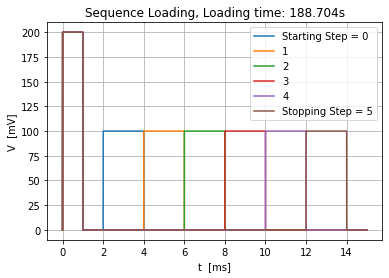

In [7]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_0']['Y1']*AWG_Settings2['Voltage Amplitude'],label= 'Starting Step = 0')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_1']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '1')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_2']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '2')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_3']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '3')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_4']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '4')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_5']['Y1']*AWG_Settings2['Voltage Amplitude'],label= 'Stopping Step = 5')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Sequence Loading, Loading time: {ab:.3f}s'.format(ab=dur))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

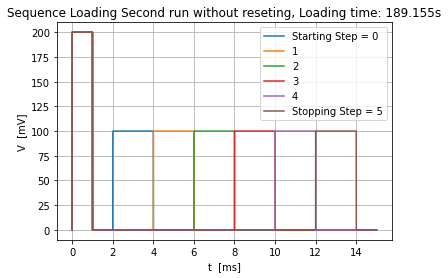

In [10]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_0']['Y1']*AWG_Settings2['Voltage Amplitude'],label= 'Starting Step = 0')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_1']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '1')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_2']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '2')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_3']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '3')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_4']['Y1']*AWG_Settings2['Voltage Amplitude'],label= '4')
plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_5']['Y1']*AWG_Settings2['Voltage Amplitude'],label= 'Stopping Step = 5')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Sequence Loading Second run without reseting, Loading time: {ab:.3f}s'.format(ab=dur) )
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [12]:
M8190A.query('SEQ:CAT?')

'0,2,2,2,4,2,6,2,8,2,10,2,12,2,14,2,16,2,18,2,20,2,22,2'

# Instrument settings after the loading.

In [11]:
M8190A.query('SEQ:CAT?')

'0,2,2,2,4,2,6,2,8,2,10,2,12,2,14,2,16,2,18,2,20,2,22,2'

In [28]:
M8190A.query('SEQ:DATA? 0,1,2')

'2,1,0,1,0,7499999,1,1,0,1,0,7499999'

In [30]:
M8190A.query('SEQ:DATA? 1,0,2')

'2,1,0,1,0,7499999,1,1,0,1,0,7499999'

In [31]:
M8190A.query('SEQ:DATA? 2,1,2')

'2,1,0,1,0,7499999,1,1,0,1,0,7499999'

# Dummy function

In [5]:
#dummy function

tic = time.time()

DataFramesPSscheme, DataFramesPSschemes2 , timeinterval = Sequence_Loader_List_D(PScheme,PScheme2,5,15,7500000,3,5,M8190A,AWG_Settings2,1,10)

toc = time.time()

dur = toc -tic

Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Dummy Segment loading ended
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"


In [8]:
dur

120.69200253486633

In [11]:
DataFramesPSscheme

{'SegmentA_7500000_3':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.666667            1              1
 2        0.666667            1              1
 3        0.666667            1              1
 4        0.666667            1              1
 ...           ...          ...            ...
 7499995  0.000000            1              1
 7499996  0.000000            1              1
 7499997  0.000000            1              1
 7499998  0.000000            1              1
 7499999  0.000000            1              1
 
 [7500000 rows x 3 columns],
 'SegmentA_7500000_4':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.666667            1              1
 2        0.666667            1              1
 3        0.666667            1              1
 4        0.666667            1              1
 ...           ...          ...            ...
 7499995  0.000000            1 

In [7]:
M8190A.query('SYST:ERR?')

'-300,"Device-specific error;CH1: Waveform file ""SegmentA_7500000_3.csv"" not found."'

In [2]:
AWG_Settings2

{'Visa Resource Name': 'TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR',
 'Voltage Amplitude': 300,
 'Clock Sample Frecuency': 500000000,
 'Output_Channel': 1,
 'Mode': 'STS',
 'Output_rout': 'DC',
 'Data Directory': 'D:\\Alejandro\\Pulses\\Dict\\S2'}

In [9]:
AWG_Settings2['Data Directory']

'D:\\Alejandro\\Pulses\\Dict\\S2'

In [5]:
type(_)

str

In [ ]:
Sequence_File(instrument,r'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentA_{a}_{b}.csv'.format(a =N,b=start),r'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentB_{a}_{b}.csv'.format(a = N,b= start),1)

In [12]:
strnga=r'{directory}\SegmentA_{a}_{b}.csv'.format(directory = AWG_Settings2['Data Directory'], a=5, b= 0)

In [13]:
strnga

'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentA_5_0.csv'

In [14]:
'{aber}'.format(aber = strnga)

'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentA_5_0.csv'